## Why is the feedback activation biased when the cue or anticipation effect is mismodeled

Author: Jeanette Mumford

In the group model simulations it is shown that when there is no feedback activation and the cue (or "feedback") true signal is mismodeled, the feedback estimate is negatively biased.  This example focuses on when the true activation is during the cue+fixation period, but only the duration of the cue is modeled.  Using a simulated data example with no noise it is easy to visually inspect the simulated data to understand what is happening.  Specifically, the cue-adjusted data and cue-adjusted feedback regressors illustrate why the cue-based regressor in the multiple linear regression is negative.

Assumptions:
* The true signal starts at the cue onset and ends at the offset of the fixation (or probe onset)
* The model of interest includes only a cue regressor (onset = cue onset, duration = cue duration of 2s) and a feedback regressor (onset is feedback onset and duration is feedback duration)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from nilearn.glm.first_level import make_first_level_design_matrix, compute_regressor

from nilearn.plotting import plot_design_matrix


### Illustration of negative feedback bias using a single subject's data

We only need one subject's data to see the general problem.

In [2]:
events_data = pd.read_csv('./AHRB/sub-01/ses-1/func/sub-01_ses-1_task-mid_run-02_events.tsv', sep='\t')


In [3]:
events_data_long = pd.melt(events_data, 
                           id_vars=['TRIAL_TYPE', 'CUE_DURATION', 'FEEDBACK_DURATION', 'PROBE_HIT'], 
                           value_vars=['CUE_ONSET', 'FEEDBACK_ONSET'],
                           var_name='onset_type',
                           value_name='onset')
events_data_long['onset_type'] = events_data_long['onset_type'].str.replace('_ONSET', '')
#events_data_long.loc[(events_data_long['onset_type'] == 'FEEDBACK') & (events_data_long['PROBE_HIT'] == 1), 'onset_type'] = 'HIT_FEEDBACK'
#events_data_long.loc[(events_data_long['onset_type'] == 'FEEDBACK') & (events_data_long['PROBE_HIT'] == 0), 'onset_type'] = 'MISS_FEEDBACK'

events_data_long['trial_type'] = events_data_long['onset_type'] #+ '_' + \
#                                 events_data_long['TRIAL_TYPE'] 
events_data_long['duration'] = events_data_long['FEEDBACK_DURATION'].copy()
events_data_long.loc[events_data_long['onset_type'] == 'CUE', 'duration'] = \
    events_data_long.loc[events_data_long['onset_type'] == 'CUE', 'CUE_DURATION']

events_data_long.drop(columns=['TRIAL_TYPE', 'CUE_DURATION', 'FEEDBACK_DURATION', 'PROBE_HIT', 'onset_type'], inplace=True)

In [4]:
# Used to generate the signal
cuefix_onset = events_data['CUE_ONSET'].copy()
cuefix_duration = events_data['CUE_DURATION'].copy() + events_data['FIXATION_DURATION'].copy()
events_data_cuefix = pd.DataFrame({'onset': cuefix_onset, 'duration': cuefix_duration})
events_data_cuefix['trial_type'] = 'cuefix'

In [5]:
scan_length = np.floor(events_data_long['onset'].max() + 20)
frame_times = np.arange(0, scan_length, 1)

desmat = make_first_level_design_matrix(
        frame_times,
        events_data_long,
        hrf_model='spm',
        drift_model=None)

cuefix_reg = make_first_level_design_matrix(
        frame_times,
        events_data_cuefix,
        hrf_model='spm',
        drift_model=None
)

In [6]:
# I'm purposely not adding noise so we can see what I'm trying to show
bold = 2 * cuefix_reg['cuefix'].values + 10

# Cue-adjusted bold and feedback signal
bold_adj_cue = sm.OLS(bold, desmat[['CUE', 'constant']]).fit().resid
feedback_adj_cue = sm.OLS(desmat['FEEDBACK'], desmat[['CUE', 'constant']]).fit().resid

## Sequential regression vs multiple linear regression

Since the sequential model is not informed of the DF that were used in the cue-adjusted models, the DF (and therefore SEs and p-values) will change a bit, but the feedback coefficient is identical.  This is just a reality check if one is not familiar with the equivalence of sequential regression and multiple linear regression.

In [7]:
mod = sm.OLS(bold, desmat).fit()
print(mod.summary(slim=True))


mod_sequential = sm.OLS(bold_adj_cue, feedback_adj_cue).fit()
print(mod_sequential.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.322
No. Observations:                 333   F-statistic:                     79.69
Covariance Type:            nonrobust   Prob (F-statistic):           5.81e-29
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CUE            1.9789      0.173     11.444      0.000       1.639       2.319
FEEDBACK      -0.3367      0.218     -1.542      0.124      -0.766       0.093
constant      10.7777      0.053    203.712      0.000      10.674      10.882

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                   OLS Regression Results                  
Dep. Variable:                      y   F-statisti

## Why the bias is negative

The short answer is because the feedback regressor is negatively associated with the BOLD data and since the cue regressor is not adequate to remove all of the activation signal, since the true duration of the signal is longer than the cue regressor's stimulus duration, much of the original signal remains after adjusting for cue.  

The first figure shows the raw data and the two regressors, illustrating that the cue regressor is not wide enough and the feedback regressor is negatively associated with the bold signal.

The second figure shows the cue-adjusted bold data and feedback regressor, which are still negatively correlated.  Had the cue regressor been able to remove all of the signal the peaks and dips of the adjusted BOLD signal would not be present.

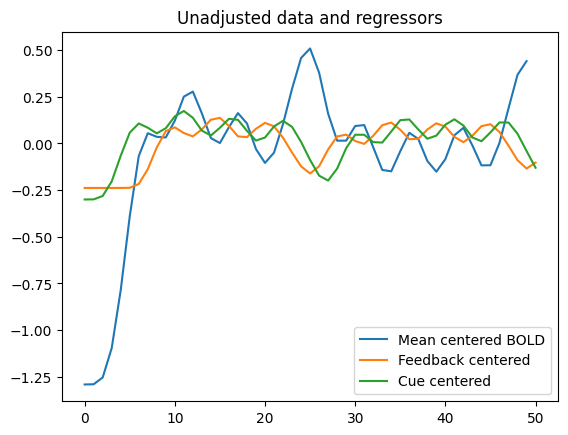

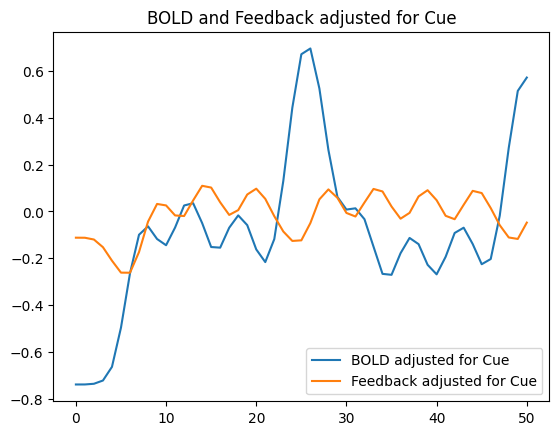

In [8]:
bold_centered = bold - np.mean(bold)
feedback_centered = desmat['FEEDBACK'] - np.mean(desmat['FEEDBACK']) 
cue_centered = desmat['CUE'] - np.mean(desmat['CUE'])
plt.plot(bold_centered[:50], label='Mean centered BOLD')
plt.plot(feedback_centered.loc[:50], label='Feedback centered')
plt.plot(cue_centered.loc[:50], label='Cue centered')
plt.title('Unadjusted data and regressors')
plt.legend()
plt.show()

plt.plot(bold_adj_cue.loc[:50], label='BOLD adjusted for Cue')
plt.plot(feedback_adj_cue.loc[:50], label='Feedback adjusted for Cue')
plt.title('BOLD and Feedback adjusted for Cue')
plt.legend()
plt.show()



## Is this a problem for all designs with cue/feedback structures

Although there is another stimulus occurring during the course of a MID trial (the probe), it is common for fMRI tasks to have some type of cue followed by a response probe with a simple two stimulus structured trial with fixation between the cue/probe pair and between trials and the MID task is often modeled in this way (ignoring the probe).  In these tasks it is difficult to know how long the neuronal activation from the cue is actually lasting and so it is likely the cue regressor is not fully capturing it, opening the door for bias in the probe activation estimate.  There is an addition consideration, which is the cue activation estimate may also be biased if the cue-based activation durations vary by cue.  For example, we know that for up to about 2s, the amplitude estimate of BOLD activation can be adjusted to fit varying durations- a 2s long stimulus modeled as 1s will have an activation estimate that is twice that of a model using the correct duration of 2s.

The following looks into biases in both the cue-based and feedback-based estimates for varying durations of cue-based activation.  In each case the cue is modeled as an "instantaneous" event (.1s) as is the feedback.  The true duration ranges from .1s to the full time of cue+fixation in the given events file used.

In [9]:
# The duration will go from .1, .5, 1, 1.5, 2, to percentages of the fixation duration (2+.25xfixation, 2+.5xfixation ...)

# Model regressors are the same for all simulations

onset_cue = np.atleast_2d(events_data['CUE_ONSET'].values)
onset_feedback = np.atleast_2d(events_data['FEEDBACK_ONSET'].values)
duration_100ms = .1 * np.ones(onset_cue.shape)
no_modulation = np.ones(onset_cue.shape)

events_data_cue = np.concatenate((onset_cue, duration_100ms, no_modulation), axis=0)
events_data_fb = np.concatenate((onset_feedback, duration_100ms, no_modulation), axis=0)

cue_reg, _ = compute_regressor(
    events_data_cue,
    'spm',
    frame_times,
    con_id = 'cue'
)

fb_reg, _ = compute_regressor(
    events_data_fb,
    'spm',
    frame_times,
    con_id = 'cue'
)

desmat = sm.add_constant(pd.DataFrame({'cue': cue_reg[:,0], 'fb': fb_reg[:,0]}))

dur_calc_vals = [(.1, 0), (.5, 0), (1, 0), (1.5, 0), (2, 0),
                        (2, .25), (2, .5), (2, .75), (2, 1)]
cue_est = []
fb_est = []
avg_dur = []
model_r2 = []
cue_adj_bold = []

for i, dur_calc_val in enumerate(dur_calc_vals):
    bold_duration = np.atleast_2d(dur_calc_val[0] + dur_calc_val[1] * events_data['FIXATION_DURATION'].values)
    avg_dur.append(np.mean(bold_duration))

    events_bold = np.concatenate((onset_cue, bold_duration, no_modulation), axis=0)
    bold_signal, _ = compute_regressor(
        events_bold,
        'spm',
        frame_times,
        'bold'
    )
    mod = sm.OLS(bold_signal, desmat).fit()
    params = mod.params
    cue_est.append(params['cue'])
    fb_est.append(params['fb'])
    model_r2.append(mod.rsquared)

    mod_cue_only = sm.OLS(bold_signal, desmat[['cue', 'const']]).fit()
    cue_adj_bold.append(mod_cue_only.resid)

    



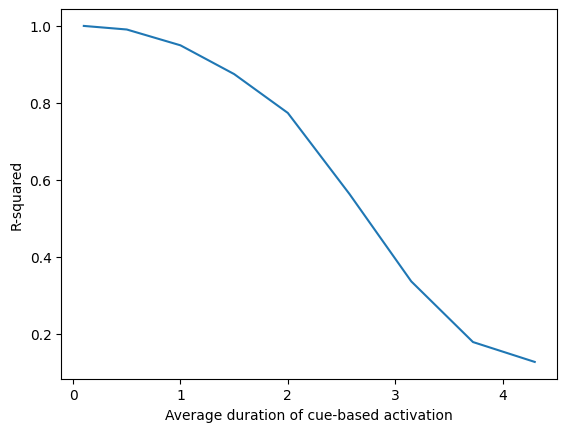

In [10]:
plt.plot(avg_dur, model_r2)
plt.xlabel('Average duration of cue-based activation')
plt.ylabel('R-squared')
plt.show()

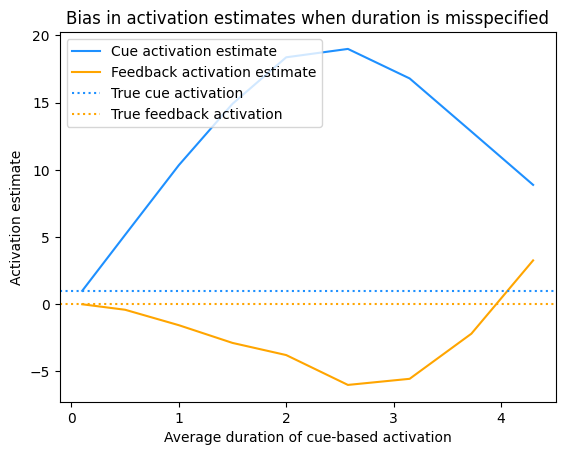

In [11]:
plt.plot(avg_dur, cue_est, label='Cue activation estimate', color='dodgerblue')
plt.plot(avg_dur, fb_est, label = 'Feedback activation estimate', color='orange')
plt.axhline(y=1, color='dodgerblue', linestyle=':', label='True cue activation')
plt.axhline(y=0, color='orange', linestyle=':', label='True feedback activation')
plt.xlabel('Average duration of cue-based activation')
plt.ylabel('Activation estimate')
plt.title('Bias in activation estimates when duration is misspecified')
plt.legend(loc='upper left')
plt.show()

### Why does the feedback bias go up?

The below figure shows the bold data after adjusting for the cue regressor for each of the simulated time series (the first 50 points).  As the true duration increases the magnitude of the signal increases, but the width also noticeably increases.  This increase in width is larger after a 2s duration is reached.  

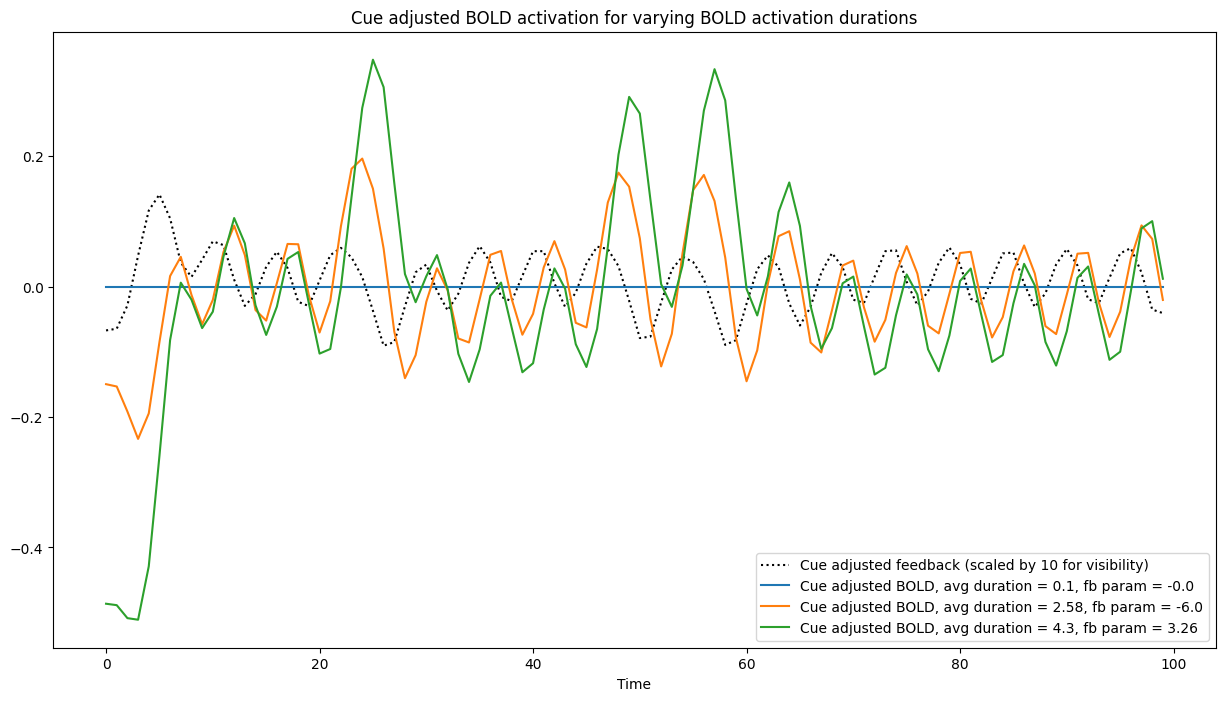

In [12]:
cue_adj_fb = sm.OLS(desmat[['cue']], desmat[['fb', 'const']]).fit().resid

plt.figure(figsize=(15, 8))
plt.plot(cue_adj_fb[:100]*10, label='Cue adjusted feedback (scaled by 10 for visibility)', 
         linestyle=':', color='black')
#for i in range(len(avg_dur)): 
for i in [0, 5, 8]:
    plt.plot(cue_adj_bold[i][:100], label=f'Cue adjusted BOLD, avg duration = {np.round(avg_dur[i], 2)}, fb param = {np.round(fb_est[i], 2)}')
plt.xlabel('Time')
plt.title('Cue adjusted BOLD activation for varying BOLD activation durations')
plt.legend(loc='lower right')
plt.show()